# Car Recognition with Deep Learning

This tutorial shows how Neural Networks are used to recognize cars on images vs. images with no cars on them (binary classification).

The data set used is the [UIUC Image Database for Car Detection](http://cogcomp.cs.illinois.edu/Data/Car/) containing:
* 1050 training images (550 car and 500 non-car images)
* 170 test images, containing 200 cars at roughly the same scale as in the training images 
(we do not use the multi-scale test images, containing 139 cars at various scales, here)

This tutorial contains:
* Image Loading and Preprocessing
* Standardization of Data
* Fully Connected Neural Networks
* Convolutional Neural Networks
* Batch Normalization
* ReLU Activation
* Dropout
* Data Augmentation

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

In [2]:
import os

# if you want to use the GPU
#device = 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np

from PIL import Image
from theano import config
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

np.random.seed(1) # we initialize a random seed here to make the experiments repeatable with same results

## Load the Images from Training Set

In [3]:
path = 'data/CarData/TrainImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 1050 files


In [4]:
images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    with Image.open(filename) as img:
        images.append(np.array(img)) # we convert the images to a Numpy array and store them in a list

pos-207.pgm


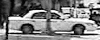

In [9]:
# show a selected image to check
i=1
print image_names[i]
Image.fromarray(images[i])

In [10]:
type(images[i])

numpy.ndarray

In [11]:
images[i].shape   # height x width   (Numpy ordering)

(40, 100)

Note: Color RGB images have an additional dimension of depth 3, e.g. (40, 100, 3)

## Make 1 big array of list of images

In [30]:
# a list of many 40x100 images is made into 1 big array
# config.floatX is from Theano configration to enforce float32 precision (needed for GPU computation)
img_array = np.array(images, dtype=config.floatX)
img_array.shape

(1050, 40, 100)

## Create the Groundtruth based on filenames:

In this data set, images with cars start with "pos-" and images with no cars start with "neg-". We create a numeric list here, containing 1 for car images and 0 for non-car images.

In [13]:
classes = []
for name in image_names:
    if name.startswith('neg'):
        classes.append(0)
    else:
        classes.append(1)

In [14]:
# look at the first 25 classes
classes[0:25]

[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]

In [15]:
print "Groundtruth Statistics:"

for v in set(classes):
    print "Class", v, ":", classes.count(v)

Groundtruth Statistics:
Class 0 : 500
Class 1 : 550


In [16]:
baseline = 550 * 1.0 / len(classes)
baseline

0.5238095238095238

The baseline is 52.3%, i.e. a 'dumb' classifier can assign all predictions to the majority class achieving this accurcay. We aim at building a classifier that performs better than that.

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

Here we use <b>Zero-mean Unit-variance standardization</b> which means we deduct the mean and divide by the standard deviation.

(Note: Here, we do this "flat", i.e. one mean and std.dev. for the whole image is computed over all pixels (not per pixel); in RGB images, standardization can be done e.g. for each colour channel individually; in other/non-image data sets, attribute-wise standardization should be applied).

In [31]:
img_array.min(), img_array.max()

(0.0, 255.0)

In [32]:
mean = img_array.mean()
stddev = img_array.std()
mean, stddev

(129.58246, 74.276726)

In [33]:
img_array = (img_array - mean) / stddev
img_array.mean(), img_array.std()

(1.2709845e-07, 0.9999997)

In [34]:
img_array.min(), img_array.max()

(-1.7445904, 1.6885173)

# Creating NN Models in Keras

## 1) Fully Connected NN

For a fully connected neural network, the x and y axis of an image do not play a role at all. All pixels are considered as a completely individual input to the neural network. Therefore the 2D image arrays have to be flattened to a vector.

In [35]:
#  flatten images to vectors
images_flat = img_array.reshape(img_array.shape[0],-1)
print images_flat.shape

(1050, 4000)


In [36]:
# find out input shape for NN, which is just a long vector (40x100 = 4000)
input_shape = images_flat.shape[1]
print input_shape

4000


### Creating a Model

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks and use the functional API (see Music/Speech tutorial).

Here we create a sequential model with 2 fully connected (a.k.a. 'dense') layers containing 256 units each.

The output unit is a Single sigmoid unit which can predict values between 0 and 1.

In [37]:
# simple Fully-connected network

model = Sequential()

model.add(Dense(256, input_dim=input_shape))

model.add(Dense(256))

model.add(Dense(1,activation='sigmoid'))


In [38]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 256)           1024256     dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 256)           65792       dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1)             257         dense_2[0][0]                    
Total params: 1,090,305
Trainable params: 1,090,305
Non-trainable params: 0
____________________________________________________________________________________________________


### Defining Loss Function and Optimizer Strategy: Gradient Descent

In [39]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
# This creates the whole model structure in memory. 
# If you use GPU computation, here GPU compatible structures and code is generated.
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

### Training the model on the input dataset

In [40]:
epochs = 15
model.fit(images_flat, classes, batch_size=32, nb_epoch=epochs) #, validation_data=validation_data) 

Epoch 1/15
1050/1050 [==============================] - 0s - loss: 0.5093 - acc: 0.7714     
Epoch 2/15
1050/1050 [==============================] - 0s - loss: 0.3085 - acc: 0.8524     
Epoch 3/15
1050/1050 [==============================] - 0s - loss: 0.2567 - acc: 0.8867     
Epoch 4/15
1050/1050 [==============================] - 0s - loss: 0.1809 - acc: 0.9267     
Epoch 5/15
1050/1050 [==============================] - 0s - loss: 0.1580 - acc: 0.9419     
Epoch 6/15
1050/1050 [==============================] - 0s - loss: 0.1303 - acc: 0.9581     
Epoch 7/15
1050/1050 [==============================] - 0s - loss: 0.1050 - acc: 0.9743     
Epoch 8/15
1050/1050 [==============================] - 0s - loss: 0.0899 - acc: 0.9829     
Epoch 9/15
1050/1050 [==============================] - 0s - loss: 0.0812 - acc: 0.9829     
Epoch 10/15
1050/1050 [==============================] - 0s - loss: 0.0678 - acc: 0.9914     
Epoch 11/15
1050/1050 [==============================] - 0s - loss: 0

In [41]:
# verify Accuracy on Train set
predictions = model.predict_classes(images_flat)
accuracy_score(classes, predictions)

 896/1050 [========================>.....] - ETA: 0s

1.0

### 100% Accuracy - perfect, no?

This is the accuracy on the training set. A (large, especially fully connected network with sufficient number of units) can easily learn the entire training set (especially a small one like here).

This very likely leads to <b>overfitting</b>. That's why we test on an independent test set.


# Testing with Test Data Set

In [42]:
path = 'data/CarData/TestImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 170 files


In [43]:
from image_preprocessing import resize_and_crop

test_images = []

for filename in files:
    with Image.open(filename) as img:
        img_resized = resize_and_crop(img,target_width=100,target_height=40)
        test_images.append(np.array(img_resized))
        #print img.size, img_resized.size

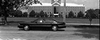

In [44]:
i=4
Image.fromarray(test_images[i])

In [45]:
# make 1 big array again from list
test_images = np.array(test_images)

### Standardize Test Set

The test data has to be standardized <b>in the same way</b> as the training data for compatibility with the model! That means, we take the mean and standard deviation of the <i>training data</i> to transform also the test data.

In [46]:
# NO! we take the same mean and stddev from the training data above!
#mean = test_images.mean()
#stddev = test_images.std()
#print mean, stddev

In [47]:
test_images.mean(), test_images.std()

(121.71342647058823, 72.05232875177191)

In [48]:
test_images = (test_images - mean) / stddev

### Flatten Images for Full model

In [49]:
test_images_flat = test_images.reshape(test_images.shape[0],-1)
print test_images_flat.shape

(170, 4000)


### Make Predictions

In [50]:
test_pred = model.predict_classes(test_images_flat)
# show 30 first predictions
test_pred[0:30,0]

 32/170 [====>.........................] - ETA: 0s

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0], dtype=int32)

In [51]:
# Groundtruth:
# this TEST SET contains ONLY CARS on images! 
# Thus all the test classes are 1
test_classes = [1] * len(files)

In [52]:
# let's count the number of ones ...
test_pred.sum()

78

As ALL our test classes are 1, counting the number of 1's and dividing by number of files gives us the Accuracy:

In [53]:
test_pred.sum() / 170.0

0.45882352941176469

The real way to do it is to compare the predictions (test_pred) with the ground truth (test_classes) and sum up the correct ones.
This is exactly what the scikit-learn function <i>accuracy_score</i> does:

In [54]:
acc = accuracy_score(test_classes, test_pred)
acc

0.45882352941176469

Accuracy on the Test Set is rather low.

# Convolutional Neural Network

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which groups neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

### Input

Our input to the CNN is the standardized version of the original image array.

#### Adding the channel

For CNNs, we need to add a dimension for the color channel to the data. RGB images typically have an 3rd dimension with the color. 
<b>For greyscale images we need to add an extra dimension for compatibility with the CNN implementation.</b>

In Theano, traditionally the color channel was the <b>first</b> dimension in the image shape. 
In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

This can be configured now in ~/.keras/keras.json: "image_dim_ordering": "th" or "tf" with "tf" (Tensorflow) being the default image ordering even though you use Theano. Depending on this, use one of the code lines below.

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [55]:
n_channels = 1 # for grey-scale, 3 for RGB, but usually already present in the data

if keras.backend.image_dim_ordering() == 'th':
    # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
    train_img = img_array.reshape(img_array.shape[0], n_channels, img_array.shape[1], img_array.shape[2])
    test_img = test_images.reshape(test_images.shape[0], n_channels, test_images.shape[1], test_images.shape[2])
else:
    # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
    train_img = img_array.reshape(img_array.shape[0], img_array.shape[1], img_array.shape[2], n_channels)
    test_img = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], n_channels)

In [56]:
img_array.shape

(1050, 40, 100)

In [57]:
train_img.shape

(1050, 1, 40, 100)

In [58]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
    
input_shape = train_img.shape[1:]  
input_shape

(1, 40, 100)

## Create the CNN model

You may try to change the following to see the impact on the result:
* number of filters
* filter kernel size (e.g. 3 x 3, 5 x 5, ...)
* adding/not adding Batch Normalization
* adding/not adding ReLU Activation
* adding/not adding Max Pooling
* changing Pooling size (e.g. 1 x 2, 2 x 2, 2 x 1, or more)
* adding/changing/removing Dropout

In [59]:
def createMyModel():
    
    model = Sequential()

    n_filters = 16
    # this applies n_filters convolution filters of size 5x5 resp. 3x3 each in the 2 layers below

    # Layer 1
    model.add(Convolution2D(n_filters, 3, 3, border_mode='valid', input_shape=input_shape))
    # input shape: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # ReLu activation
    model.add(MaxPooling2D(pool_size=(2, 2))) # reducing image resolution by half
    model.add(Dropout(0.3))  # random "deletion" of %-portion of units in each batch

    # Layer 2
    model.add(Convolution2D(n_filters, 3, 3))  # input_shape is only needed in 1st layer
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten()) # Note: Keras does automatic shape inference.
    
    # Full Layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1,activation='sigmoid'))
    
    return model

In [60]:
model = createMyModel()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 38, 98)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 16, 38, 98)    392         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 38, 98)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 19, 49)    0           activation_1[0][0]               
___________________________________________________________________________________________

Note: If you get OverflowError: Range exceeds valid bounds in the above box, check the correct Theano vs. Tensorflow ordering in the box before and your keras.json configuration file.

## Training the CNN

In [61]:
# Compiling the model
loss = 'binary_crossentropy' 
optimizer = 'sgd' 
#optimizer = SGD(lr=0.001)  # possibility to adapt the learn rate

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [62]:
# TRAINING the model
epochs = 15
history = model.fit(train_img, classes, batch_size=32, nb_epoch=epochs)

Epoch 1/15
1050/1050 [==============================] - 0s - loss: 0.4806 - acc: 0.8295     
Epoch 2/15
1050/1050 [==============================] - 0s - loss: 0.1493 - acc: 0.9524     
Epoch 3/15
1050/1050 [==============================] - 0s - loss: 0.1270 - acc: 0.9495     
Epoch 4/15
1050/1050 [==============================] - 0s - loss: 0.0847 - acc: 0.9648     
Epoch 5/15
1050/1050 [==============================] - 0s - loss: 0.0675 - acc: 0.9762     
Epoch 6/15
1050/1050 [==============================] - 0s - loss: 0.0612 - acc: 0.9790     
Epoch 7/15
1050/1050 [==============================] - 0s - loss: 0.0476 - acc: 0.9819     
Epoch 8/15
1050/1050 [==============================] - 0s - loss: 0.0564 - acc: 0.9800     
Epoch 9/15
1050/1050 [==============================] - 0s - loss: 0.0383 - acc: 0.9867     
Epoch 10/15
1050/1050 [==============================] - 0s - loss: 0.0386 - acc: 0.9895     
Epoch 11/15
1050/1050 [==============================] - 0s - loss: 0

Note: If you get ValueError: GpuDnnConv images and kernel must have the same stack size, best upgrade Keras to 1.2.0 as we experienced this problem when using BatchNormalization in Keras 1.1.2.

<b>Again, our Accuracy rises quickly to almost 100%, with the CNN now even faster than with the Fully Connected Network.
But is our model really good at predicting unseen data?</b>

### Training with Validation Data

We split off 10 % of the training data and use it as independend validation set to verify how good we are
on an independent data (not used for training) in each epoch

In [63]:
# recreate and recompile the model (otherwise we continue learning)
model = createMyModel()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# train with showing accuracy on split off validation data
history = model.fit(train_img, classes, batch_size=32, nb_epoch=epochs, validation_split=0.1) # portion of val. data

Train on 945 samples, validate on 105 samples
Epoch 1/15
945/945 [==============================] - 0s - loss: 0.5864 - acc: 0.7841 - val_loss: 0.4166 - val_acc: 0.7905
Epoch 2/15
945/945 [==============================] - 0s - loss: 0.1894 - acc: 0.9259 - val_loss: 0.2158 - val_acc: 0.9619
Epoch 3/15
945/945 [==============================] - 0s - loss: 0.1054 - acc: 0.9630 - val_loss: 0.1644 - val_acc: 0.9429
Epoch 4/15
945/945 [==============================] - 0s - loss: 0.0873 - acc: 0.9683 - val_loss: 0.1035 - val_acc: 0.9714
Epoch 5/15
945/945 [==============================] - 0s - loss: 0.1006 - acc: 0.9577 - val_loss: 0.0904 - val_acc: 0.9714
Epoch 6/15
945/945 [==============================] - 0s - loss: 0.0784 - acc: 0.9746 - val_loss: 0.0726 - val_acc: 1.0000
Epoch 7/15
945/945 [==============================] - 0s - loss: 0.0551 - acc: 0.9841 - val_loss: 0.0612 - val_acc: 1.0000
Epoch 8/15
945/945 [==============================] - 0s - loss: 0.0552 - acc: 0.9841 - val_l

The results on the split-off validation data are quite high (usually similar, but not as high as on the training data).

### Using Test Set as Validation Set

<b>Note: This usually is not recommended as during experimentation you will overfit also to the test data.</b>

We show it here only for demonstration purposes to see how (bad) the validation accuracy is on our independet test data. The recommended way is to have a separate training, validation and test set (i.e. 3 splits or separate data sets).

In [64]:
# recreate and recompile the model (otherwise we continue learning)
model = createMyModel()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# show result on Test Data while training 
# we use test data as validation data to see direct results (usually NOT RECOMMENDED due to overfitting to the problem!)
validation_data = (test_img, test_classes)

history = model.fit(train_img, classes, batch_size=32, nb_epoch=epochs, validation_data=validation_data) 

Train on 1050 samples, validate on 170 samples
Epoch 1/15
1050/1050 [==============================] - 0s - loss: 0.3967 - acc: 0.8200 - val_loss: 0.8703 - val_acc: 0.3588
Epoch 2/15
1050/1050 [==============================] - 0s - loss: 0.1710 - acc: 0.9429 - val_loss: 1.7188 - val_acc: 0.1118
Epoch 3/15
1050/1050 [==============================] - 0s - loss: 0.1010 - acc: 0.9619 - val_loss: 2.3172 - val_acc: 0.0647
Epoch 4/15
1050/1050 [==============================] - 0s - loss: 0.0838 - acc: 0.9695 - val_loss: 2.7548 - val_acc: 0.0706
Epoch 5/15
1050/1050 [==============================] - 0s - loss: 0.0445 - acc: 0.9857 - val_loss: 3.8368 - val_acc: 0.0471
Epoch 6/15
1050/1050 [==============================] - 0s - loss: 0.0477 - acc: 0.9819 - val_loss: 4.3550 - val_acc: 0.0588
Epoch 7/15
1050/1050 [==============================] - 0s - loss: 0.0308 - acc: 0.9914 - val_loss: 3.2424 - val_acc: 0.1000
Epoch 8/15
1050/1050 [==============================] - 0s - loss: 0.0526 - ac

In [78]:
history.history

{'acc': [0.81999999965940207,
  0.94285714217594696,
  0.96190476122356594,
  0.96952380952380957,
  0.98571428503308978,
  0.98190476122356596,
  0.99142857142857144,
  0.97809523809523813,
  0.99333333265213741,
  0.99714285646166123,
  0.99523809523809526,
  0.99428571428571433,
  0.99333333333333329,
  0.99904761904761907,
  0.99238095238095236],
 'loss': [0.39672894330251784,
  0.17101604864710854,
  0.10101084103186925,
  0.083790038146433377,
  0.044469028853234789,
  0.047731710636899585,
  0.030785161579648654,
  0.052611949464217538,
  0.023272062653586979,
  0.017700184312249932,
  0.017168679502570915,
  0.018818419288311686,
  0.017184943739945689,
  0.011223928680022558,
  0.016917803221870035],
 'val_acc': [0.35882352976238024,
  0.11176470597000683,
  0.064705882352941183,
  0.07058823538177153,
  0.047058823529411764,
  0.058823529411764705,
  0.10000000008765389,
  0.082352941264124471,
  0.14117647067588918,
  0.11176470597000683,
  0.064705882440595067,
  0.05294117

<b>On the test set we perform really bad: less than 10% Accuracy!</b>

### Verifying Accuracy on Test Set

In [65]:
test_pred = model.predict_classes(test_img)
# show 35 first predictions
test_pred[0:35,0]

170/170 [==============================] - 0s     


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [66]:
predictions = model.predict_classes(test_img)
accuracy_score(test_classes, predictions)

160/170 [===========================>..] - ETA: 0s

0.082352941176470587

#### Conclusion: We are completely overfitting!
While we achieve nearly 100% on the Training Set, the generalization to the Test Set is really bad, with an Accuracy of about only 10%.

# Data Augmentation

Increase the training set by adding more images: Rotate, shift, flip and scale the original images to generate additional examples that will help the Neural Network to generalize better.

In [67]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [68]:
# ImageDataGenerator needs the classes as Numpy array instead of normal list
classes_array = np.array(classes)

In [75]:
np.random.seed(0) # enforce repeatable result

In [76]:
# recreate and recompile the model (otherwise we continue learning)
model = createMyModel()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(train_img, classes_array, batch_size=16),
                    samples_per_epoch=len(train_img), nb_epoch=epochs,
                    validation_data=validation_data) 

Epoch 1/15
1050/1050 [==============================] - 1s - loss: 0.7123 - acc: 0.6010 - val_loss: 0.8059 - val_acc: 0.2118
Epoch 2/15
1050/1050 [==============================] - 1s - loss: 0.5517 - acc: 0.7010 - val_loss: 0.8343 - val_acc: 0.3118
Epoch 3/15
1050/1050 [==============================] - 1s - loss: 0.5087 - acc: 0.7524 - val_loss: 1.0815 - val_acc: 0.1118
Epoch 4/15
1050/1050 [==============================] - 1s - loss: 0.4209 - acc: 0.8029 - val_loss: 0.9153 - val_acc: 0.3765
Epoch 5/15
1050/1050 [==============================] - 1s - loss: 0.4048 - acc: 0.8162 - val_loss: 1.1389 - val_acc: 0.2647
Epoch 6/15
1050/1050 [==============================] - 1s - loss: 0.3704 - acc: 0.8438 - val_loss: 0.8409 - val_acc: 0.4824
Epoch 7/15
1050/1050 [==============================] - 1s - loss: 0.3726 - acc: 0.8362 - val_loss: 0.6340 - val_acc: 0.6412
Epoch 8/15
1050/1050 [==============================] - 1s - loss: 0.3397 - acc: 0.8581 - val_loss: 0.9270 - val_acc: 0.4471


### Verifying Accuracy on Test Set (with Data Augmentation)

In [71]:
test_pred = model.predict_classes(test_img)
test_pred[0:35,0] # show 35 first predictions

160/170 [===========================>..] - ETA: 0s

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], dtype=int32)

In [72]:
predictions = model.predict_classes(test_img)
accuracy_score(test_classes, predictions)

160/170 [===========================>..] - ETA: 0s

0.6705882352941176

<b>Conclusion: With Data Augmentation, the model has more diverse training examples and generalizes much better. The Accuracy on the Test Set increases from less than 10% to more than 55% up to 75%!</b>